In [1]:
# importing necessary libraries
import numpy as np
import time
import cv2
import os

from google.colab.patches import cv2_imshow

In [2]:
# defining the default configurations
THRESH = 0.3
CONFIDENCE = 0.5
INPUT_DIM = (800 , 600)
IMAGE_PATH = "images/cat-dog.jpg"

In [3]:
# Changing the directory into notebooks paths
%cd /content/drive/MyDrive/My Projects/YOLO-pretrained-model

/content/drive/MyDrive/My Projects/YOLO-pretrained-model


In [4]:
# loading the coco data and labels that yolo algorithm was trained on
labelsPath = os.path.sep.join(["yolo-coco" , "coco.names"])
# reading the labels by their path, remving the potential white spaces and split them by \n
LABELS = open(labelsPath).read().strip().split("\n")

# initializing some random colors for each label
np.random.seed(42)
COLORS = np.random.randint(0 , 255 , size = (len(LABELS) , 3) , dtype = "uint8")

In [5]:
# passing the yolo weight and yolo config file locations into some varialbles
weightsPath = os.path.sep.join(["yolo-coco" , "yolov3.weights"])
configPath = os.path.sep.join(["yolo-coco" , "yolov3.cfg"])

# loading the pretrained yolo model using opencv module
net = cv2.dnn.readNetFromDarknet(configPath , weightsPath)

In [6]:
# reading the image, resizing it and then getting its height and width
image = cv2.imread(IMAGE_PATH)
image = cv2.resize(image , INPUT_DIM)
(H , W) = image.shape[:2]

# determine only the *output* layer names that we need from yolo
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# before feeding the image to the yolo to get the bounding boxes and probabilities
# first we have to preprocess our input image
blob = cv2.dnn.blobFromImage(image , 1 / 255.0 , (416 , 416) , 
                             swapRB = True , crop = False)

# performing a forwardpass through the yolo
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()

print("The YOLO algorithm took {:.3f} seconds...".format(end - start))

The YOLO algorithm took 2.147 seconds...


In [7]:
# initializing the list of detected bounding boxes, confidence
# and class IDs
boxes = []
confidences = []
classIDs = []

In [8]:
# looping over each of the layer output
for output in layerOutputs:
  # looping over each of the detections
  for detection in output:
    # extracting the clase ID and the confidence
    # for each of the current object detection
    scores = detection[5:]
    classID = np.argmax(scores)
    confidence = scores[classID]

    if confidence > CONFIDENCE:
      # YOLO returns the (x,y) center coordinates of the ROI
      # so we have to scale it to the relative size of an image
      box = detection[0:4] * np.array([W , H , W , H])
      (centerX , centerY , width , height) = box.astype("int")
      
      # using the (x , y) center coordinates to calculate the top left
      # corner coordinate of the bounding box
      x = int(centerX - (width / 2))
      y = int(centerY - (height / 2))

      boxes.append([x , y , int(width) , int(height)])
      confidences.append(float(confidence))
      classIDs.append(classID)

In [9]:
# using the cv2 nonMaxSuppression function to remove redundant
# overlapping bounding boxes
idxs = cv2.dnn.NMSBoxes(boxes , confidences , CONFIDENCE,
                        THRESH)

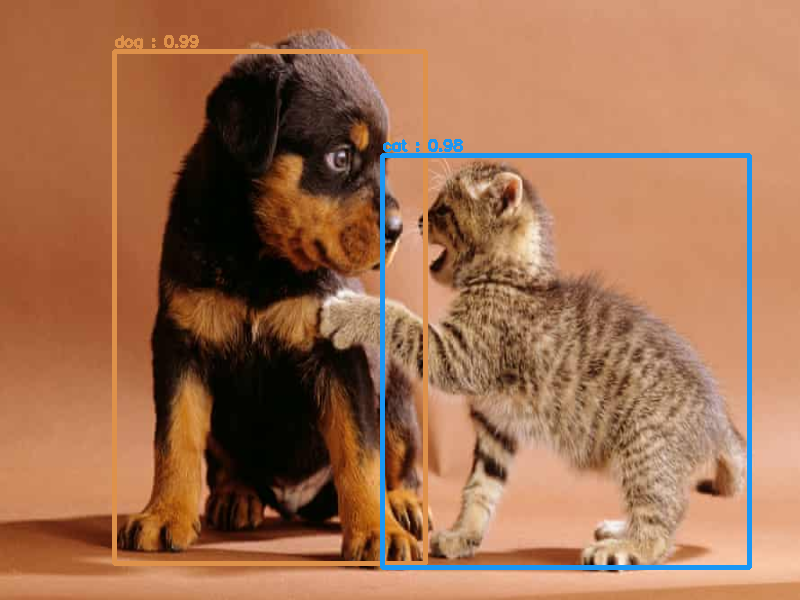

True

In [10]:
# ensuring that at least one detection exists
if len(idxs) > 0:
  for i in idxs.flatten():

    # extracting the bounding box coordinates
    (x , y) = (boxes[i][0] , boxes[i][1])
    (w , h) = (boxes[i][2], boxes[i][3])

    # drawing the bounding box rectangle(s)
    color = [int(c) for c in COLORS[classIDs[i]]]
    cv2.rectangle(image,  (x , y) , (x + w , y + h) , 
                  color , 3)
    text = "{} : {:.2f}".format(LABELS[classIDs[i]] , confidences[i])
    cv2.putText(image ,text , (x , y - 5) , cv2.FONT_HERSHEY_SIMPLEX,
                0.5 , color , 2)

cv2_imshow(image)
cv2.imwrite("image_outputs/cat-dog.jpg" , image)